In [1]:
import os
import shutil
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import geopandas as gpd
from pathlib import Path
from shapely.geometry import Point, MultiPoint, LineString
from pprint import pprint

import hydromt

from hydromt.log import setuplog
from hydromt_sfincs import SfincsModel, utils

logger = setuplog("prepare data catalog", log_level=10)

2024-04-13 13:45:01,753 - prepare data catalog - log - INFO - HydroMT version: 0.9.4


### 1. Initialize SfincsModel class, set data library and output folder:

In [2]:
model_name = "garissa_depth2m_fabdem_grid100_avg_lin"
grid_size = 100
constant_river_depth = 2
nr_subgrid_pixels = 4
use_lin_river = True

In [3]:
data_libs = [
    Path(r"data/1_static/data_static_tana.yml"),
]
model_root = Path(fr"model/{model_name}")

data_catalog = hydromt.DataCatalog(data_libs=data_libs, logger=logger)

model = SfincsModel(root=model_root, data_libs=data_libs, mode="w+", logger=logger)

2024-04-13 13:45:01,792 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_tana.yml
2024-04-13 13:45:01,816 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\2_forcing\data_forcing.yml
2024-04-13 13:45:01,995 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\1_static\data_static_tana.yml
2024-04-13 13:45:02,030 - prepare data catalog - data_catalog - INFO - Parsing data catalog from data\2_forcing\data_forcing.yml
2024-04-13 13:45:02,037 - prepare data catalog - model_api - WARNING - Model dir already exists and files might be overwritten: c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\garissa_depth2m_fabdem_grid100_avg_lin\gis.
2024-04-13 13:45:02,039 - prepare data catalog - log - DEBUG - Appending log messages to file c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\garissa_depth2m_fabdem_grid100_avg_lin\hydromt.log.
2024

### 2. Configure the time for which the model runs

In [4]:
model.setup_config(
    **{
        "tref":     "20230901 000000",
        "tstart":   "20230901 000000",
        "tstop":    "20231231 000000",
    }
)

print(model.config)

2024-04-13 13:45:02,066 - prepare data catalog - model_api - DEBUG - Setting model config options.
{'mmax': 10, 'nmax': 10, 'dx': 10.0, 'dy': 10.0, 'x0': 0.0, 'y0': 0.0, 'rotation': 0.0, 'latitude': 0.0, 'tref': '20230901 000000', 'tstart': '20230901 000000', 'tstop': '20231231 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015]}


### 3. Specify characteristics of the wanted grid and generate grid:

Region file found?  True
2024-04-13 13:45:02,106 - prepare data catalog - geodataframe - INFO - Reading  vector data from data\1_static\regions\region_garissa_5km_buffer.geojson


2024-04-13 13:45:02,244 - prepare data catalog - basin_mask - DEBUG - Parsed region (kind=geom): {'geom': 'GeoDataFrame [4402409.89783  -63608.17479 4423462.84213  -39354.37785] (crs = EPSG:3857)'}
{'mmax': 211, 'nmax': 243, 'dx': 100, 'dy': 100, 'x0': 4402410.0, 'y0': -63608.0, 'rotation': 0, 'latitude': 0.0, 'tref': '20230901 000000', 'tstart': '20230901 000000', 'tstop': '20231231 000000', 'tspinup': 60.0, 'dtout': 3600.0, 'dthisout': 600.0, 'dtrstout': 0.0, 'dtmaxout': 86400, 'trstout': -999.0, 'dtwnd': 1800.0, 'alpha': 0.5, 'theta': 1.0, 'huthresh': 0.01, 'manning': 0.04, 'manning_land': 0.04, 'manning_sea': 0.02, 'rgh_lev_land': 0.0, 'zsini': 0.0, 'qinf': 0.0, 'rhoa': 1.25, 'rhow': 1024.0, 'dtmax': 60.0, 'advection': 1, 'baro': 0, 'pavbnd': 0, 'gapres': 101200.0, 'stopdepth': 100.0, 'crsgeo': 0, 'btfilter': 60.0, 'viscosity': 1, 'inputformat': 'bin', 'outputformat': 'net', 'cdnrb': 3, 'cdwnd': [0.0, 28.0, 50.0], 'cdval': [0.001, 0.0025, 0.0015], 'epsg': 3857}


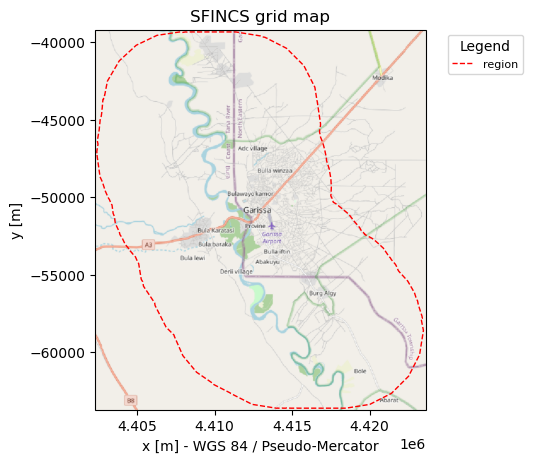

In [5]:
region_path = Path(r"data/1_static/regions/region_garissa_5km_buffer.geojson")

print("Region file found? ", os.path.isfile(region_path))

model.setup_grid_from_region(
    region={"geom":region_path},
    res=grid_size,
    crs="3857",
)

print(model.config)

_ = model.plot_basemap(variable="grid", plot_region=True, bmap="osm")

### 4. Load in wanted elevation datasets and set the active cells:

In [6]:
datasets_dep = [{"elevtn": "fabdem"}]
model.setup_dep(datasets_dep=datasets_dep)

model.setup_mask_active(mask=region_path, zmin=-5, reset_mask=True)

2024-04-13 13:45:09,038 - prepare data catalog - rasterdataset - INFO - Reading fabdem raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\fabdem\fabdem.tif


2024-04-13 13:45:09,189 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-13 13:45:09,765 - prepare data catalog - merge - DEBUG - Reprojection method of first dataset is: average
2024-04-13 13:45:09,787 - prepare data catalog - geodataframe - INFO - Reading  vector data from data\1_static\regions\region_garissa_5km_buffer.geojson
2024-04-13 13:45:09,829 - prepare data catalog - geodataframe - DEBUG - Clip intersects [39.548, -0.571, 39.737, -0.354] (EPSG:4326)
2024-04-13 13:45:09,886 - prepare data catalog - regulargrid - INFO - 0 gaps outside valid elevation range < 10.0 km2.
2024-04-13 13:45:09,892 - prepare data catalog - sfincs - INFO - Derive region geometry based on active cells.
2024-04-13 13:45:09,909 - prepare data catalog - model_api - WARNING - Replacing geom: region


### 5. Add river inflow/outflow points:

2024-04-13 13:45:09,941 - prepare data catalog - geodataframe - INFO - Reading rivers_lin2019_v1 vector data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\data_river_lin\tana_lin_crs_reprojected.geojson
2024-04-13 13:45:10,611 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4402410.000, -63608.000, 4423510.000, -39308.000] (EPSG:3857)
2024-04-13 13:45:10,648 - prepare data catalog - sfincs - INFO - Found 1 river inflow points.


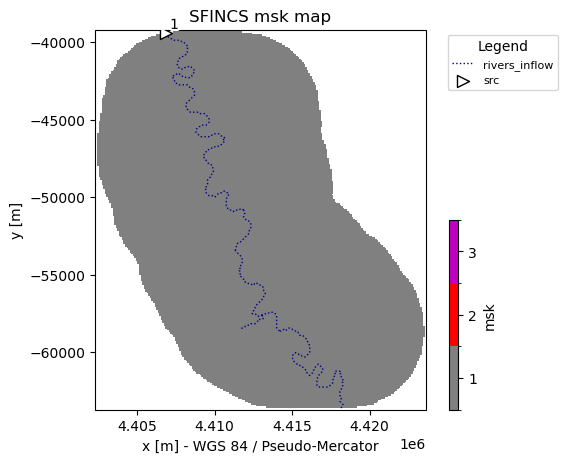

In [7]:
river_len = 100 # km
river_upa = 100 # km2
river_width = 150 # m

# We load in the Lin et al. dataset
if use_lin_river:
    centerlines = data_catalog.get_geodataframe("rivers_lin2019_v1")
    model.setup_river_inflow(
        rivers = centerlines,
        reverse_river_geom = True,
        keep_rivers_geom=True,
    )

else:
    model.setup_river_inflow(
        hydrography="merit_hydro", 
        river_len=river_len, 
        river_upa=river_upa, 
        river_width=river_width, 
        keep_rivers_geom=True
    )

fig, ax = model.plot_basemap(variable="msk", plot_bounds=True)

### 6. Update mask with water level and outflow boundary cells - including use of polygons:

2024-04-13 13:45:11,400 - prepare data catalog - regulargrid - DEBUG - outflow (mask=3) boundary cells reset.


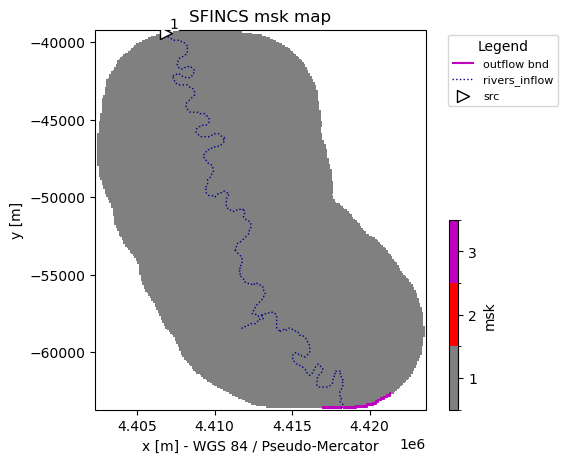

In [8]:
model.setup_mask_bounds(btype="outflow", zmax=135, reset_bounds=True)
# model.setup_mask_bounds(btype="waterlevel", include_mask="osm_coastlines", reset_bounds=True)

fig, ax = model.plot_basemap(variable="msk", plot_bounds=True)

### 7. Add spatially varying roughness data, burn river into DEM, create subgrid.

In [9]:
datasets_rgh = [{"lulc": "vito"}]

In [10]:
gdf_riv = model.geoms["rivers_inflow"].copy()

riv_depth = constant_river_depth
riv_manning = 0.03

datasets_riv = [{"centerlines": gdf_riv, "mask":"grwl_mask_vector", "rivdph":riv_depth, "manning":riv_manning}]

2024-04-13 13:45:12,465 - prepare data catalog - rasterdataset - INFO - Reading fabdem raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\fabdem\fabdem.tif


2024-04-13 13:45:12,512 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-13 13:45:12,528 - prepare data catalog - rasterdataset - INFO - Reading vito raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\landuse\landuse_vito_tana1.tif
2024-04-13 13:45:12,575 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))
2024-04-13 13:45:12,578 - prepare data catalog - dataframe - INFO - Reading  csv data from c:\Users\pjdeb\anaconda3\envs\sfincs\lib\site-packages\hydromt_sfincs\data\lulc\vito_mapping.csv


The nodata value None is not in the reclass table.None will be used for the params.


2024-04-13 13:45:12,612 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4401410.000, -64608.000, 4424510.000, -38308.000] (EPSG:3857)
2024-04-13 13:45:12,629 - prepare data catalog - geodataframe - INFO - Reading grwl_mask_vector vector data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\grwl_rivermask\grwl_mask_vector_tana.gpkg
2024-04-13 13:45:13,937 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4402410.000, -63608.000, 4423510.000, -39308.000] (EPSG:3857)
2024-04-13 13:45:13,980 - prepare data catalog - subgrid - INFO - Number of regular cells in a block : 500
2024-04-13 13:45:13,981 - prepare data catalog - subgrid - INFO - Number of blocks in n direction    : 1
2024-04-13 13:45:13,981 - prepare data catalog - subgrid - INFO - Number of blocks in m direction    : 1
2024-04-13 13:45:13,983 - prepare data catalog - subgrid - INFO - Grid size of flux grid            : dx=100.0, dy=100.0
2024-04-13 13:45:13

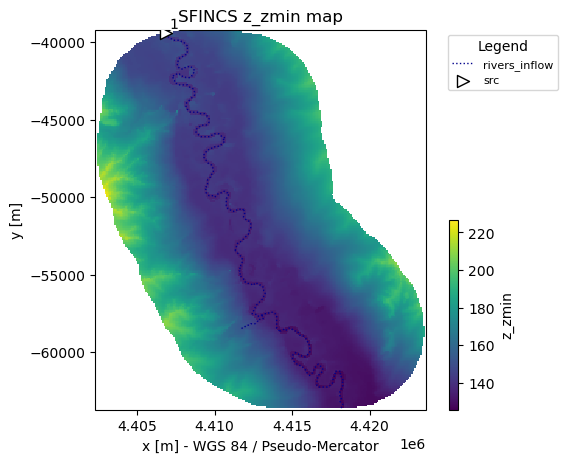

In [11]:
model.setup_subgrid(
    datasets_dep=datasets_dep,
    datasets_rgh=datasets_rgh,
    datasets_riv=datasets_riv,
    nr_subgrid_pixels=nr_subgrid_pixels,
    write_dep_tif=True,
    write_man_tif=False,
)
# uncomment to see the subgrid table variales
# sf.subgrid

# we can plot the 2D subgrid variables
_ = model.plot_basemap(
    variable="subgrid.z_zmin", plot_bounds=False, zoomlevel=12
)

### 8. Add spatially varying infiltration data:

In [12]:
model.setup_cn_infiltration("gcn250", antecedent_moisture="avg")

2024-04-13 13:45:36,241 - prepare data catalog - rasterdataset - INFO - Reading gcn250 raster data from c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\data\1_static\gcn250\{variable}.tif
2024-04-13 13:45:36,418 - prepare data catalog - rasterdataset - DEBUG - Clip to [39.548, -0.571, 39.737, -0.353] (epsg:4326))


### 9. Add an upstream discharge time-series as forcing:

2024-04-13 13:45:37,131 - prepare data catalog - dataframe - DEBUG - Slicing time dime (datetime.datetime(2023, 9, 1, 0, 0), datetime.datetime(2023, 12, 31, 0, 0))
2024-04-13 13:45:37,331 - prepare data catalog - model_api - WARNING - Replacing forcing: dis


Text(0, 0.5, 'discharge [m3/s]')

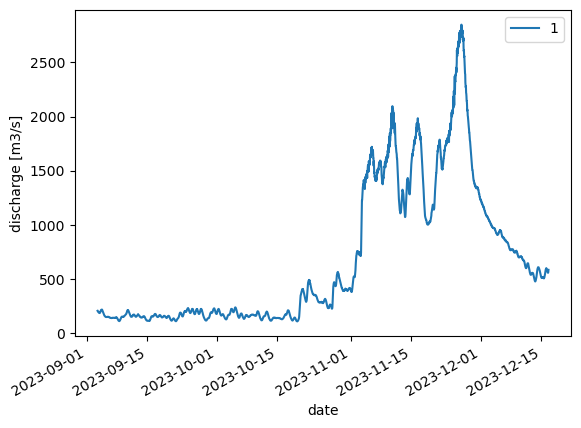

In [13]:
fpath_dis = Path(r"C:/Users/pjdeb/OneDrive/Documenten/Universiteit/CT 5/MDP/data_sens/wra/clean_data_mats/fixed_all_data_Garissa.csv")

discharge_garissa = pd.read_csv(fpath_dis, parse_dates=['date'], index_col='date')
discharge_garissa.index = pd.to_datetime(discharge_garissa.index, format="mixed")

start_date = pd.to_datetime(model.config["tstart"])
end_date = pd.to_datetime(model.config["tstop"])

###############################################################
discharge_garissa = discharge_garissa[(discharge_garissa.index >= start_date) & (discharge_garissa.index <= end_date)]
index = model.forcing["dis"].index
dis = pd.DataFrame(index=discharge_garissa.index, columns=index)

dis[1] = discharge_garissa["discharge[m3/s]"]

model.setup_discharge_forcing(timeseries=dis, buffer=1000)
dis.plot()
# plt.yticks([])
plt.ylabel("discharge [m3/s]")

In [14]:
# index = model.forcing["dis"].index

# time = pd.date_range(
#     model.config["tstart"],
#     model.config["tstop"]
# )

# dis = np.zeros((len(time), len(index)))

# dis[0:70, 0] = 10
# dis[100:107, 0] = 10
# dis[107:, 0] = 10

# dispd = pd.DataFrame(index=time, columns=index, data=dis)

# model.setup_discharge_forcing(timeseries=dispd, buffer=500)

# # model.forcing.keys()

# dispd.plot()

### 10. Add observation points (water level) and lines (discharge):

In [35]:
garissa_gauge_coords = 39.636760, -0.463964    # EPSG: 4326

observation_points = {'station': ['garissa'], 'geometry': [Point(garissa_gauge_coords).reverse()]}
gdf = gpd.GeoDataFrame(observation_points, crs="EPSG:4326")
model.setup_observation_points(
    locations=gdf, merge=False)

# We also add observation points every x km
# Function to interpolate points along a LineString
# def interpolate_points(line, distance=1):
#     total_length = line.length
#     points = []
    
#     # Interpolate points along the LineString at intervals
#     for d in np.arange(0, total_length, distance * 1000):  # Convert km to meters
#         point = line.interpolate(d)
#         points.append(point)
#     return points

# all_points = []
# for geom in gdf_riv['geometry']:
#     points = interpolate_points(geom, 10)
#     all_points.extend(points)
# # multi_point = MultiPoint(all_points)
# points_gdf = gpd.GeoDataFrame(geometry=all_points, crs="EPSG:3857")


# model.setup_observation_points(points_gdf, merge=True)

2024-04-13 13:55:27,004 - prepare data catalog - geodataframe - DEBUG - Clip intersects [4402410.000, -63608.000, 4423510.000, -39308.000] (EPSG:3857)
2024-04-13 13:55:27,009 - prepare data catalog - model_api - WARNING - Replacing geom: obs


### 11. Save all files

In [36]:
model.write()
# Show created files in folder:
dir_list = os.listdir(model.root)
print(dir_list)
print(model.config)

2024-04-13 13:55:27,662 - prepare data catalog - sfincs - INFO - Writing model data to c:\Users\pjdeb\OneDrive\Documenten\Universiteit\CT 5\MDP\Git\MDP\SFINCS\model\garissa_depth2m_fabdem_grid100_avg_lin
2024-04-13 13:55:27,663 - prepare data catalog - sfincs - DEBUG - Write binary map indices based on mask.
2024-04-13 13:55:27,666 - prepare data catalog - sfincs - DEBUG - Write binary map files: ['msk', 'dep', 'scs'].
2024-04-13 13:55:27,716 - prepare data catalog - sfincs - INFO - Write raster file(s) for grid to 'gis' subfolder
2024-04-13 13:55:27,933 - prepare data catalog - sfincs - INFO - Write geom files
2024-04-13 13:55:27,938 - prepare data catalog - sfincs - INFO - Write vector file(s) for geoms to 'gis' subfolder
2024-04-13 13:55:27,996 - prepare data catalog - sfincs - INFO - Write forcing files
2024-04-13 13:55:28,047 - prepare data catalog - sfincs - INFO - Write vector file(s) for forcing.dis to 'gis' subfolder
2024-04-13 13:55:28,092 - prepare data catalog - sfincs - WA

### 12. Show final model

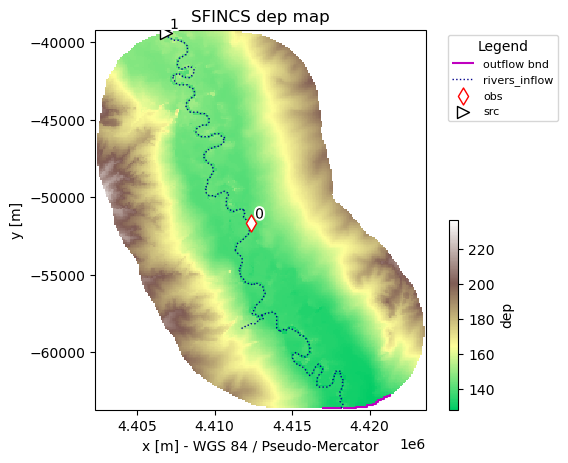

In [37]:
_ = model.plot_basemap(fn_out="basemap.png", zoomlevel=12)

plt.savefig(Path(fr"figs/{model_name}"))